In [1]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
import datetime
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import operator
from numpy import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
import itertools
from sklearn.neighbors import KNeighborsClassifier

### Testing and training the final training data.

<https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.LabelEncoder.html><br>
<https://chrisalbon.com/machine_learning/preprocessing_structured_data/convert_pandas_categorical_column_into_integers_for_scikit-learn/>
<p>Let's create our random forest dataframe from final_df.csv that was made in West Nile Predictor - Creation of Final Dataframe.ipynb. Let's also turn the string values of trap into increment values using LabelEncoder. If we don't do this then random forest gives us an error: ValueError: could not convert string to float: 'T011'" (that's the first value in trap).</p>

In [2]:
final_df = pd.read_csv('final_df.csv')

In [3]:
accuracy_list = []

<https://docs.python.org/3/library/datetime.html#datetime.date.fromordinal> 

<p>date.toordinal is used to convert the dates that are interpreted as strings to ordinal values which are ints. This allows logistic regression to use them because it doesn't want strings. This also allows us to use the Date feature because before it was dropped entirely.</p>

In [4]:
#create a label (category) encoder object
le = preprocessing.LabelEncoder()

#fit the encoder to the pandas column
le.fit(list(final_df['Trap'].values))

#view labels
print(le.classes_)

#apply the fitted encoder to the pandas columns
final_df['Trap'] = le.transform(list(final_df['Trap'].values))

#add a column that holds the ordinal versions of our dates
final_df['Date Ordinal'] = pd.to_datetime(final_df['Date']).apply(lambda date: date.toordinal())

#dropping date since random forest won't work with datetime and wants it as a float or int
#we have the ordinal versions now that are ints
final_df.drop('Date', axis=1, inplace=True)

#columns to change from float64 to int64
cols_to_int = ['WnvPresent', 'CULEX ERRATICUS', 'CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX SALINARIUS',
               'CULEX TARSALIS', 'CULEX TERRITANS', '<= 90 days', '<= 183 days', '<= 365 days', '<= 730 days', '> 730 days',
              '<= 1/2 mile', '<= 1 mile', '<= 3 miles', '<= 5 miles', '> 5 miles']

#changing features type to int64
final_df[cols_to_int] = final_df[cols_to_int].astype('int64')

display(final_df.head(3), final_df.info())



['T001' 'T002' 'T003' 'T004' 'T005' 'T006' 'T007' 'T008' 'T009' 'T011'
 'T012' 'T013' 'T014' 'T015' 'T016' 'T017' 'T018' 'T019' 'T025' 'T027'
 'T028' 'T030' 'T031' 'T033' 'T034' 'T035' 'T036' 'T037' 'T039' 'T040'
 'T043' 'T044' 'T045' 'T046' 'T047' 'T048' 'T049' 'T050' 'T051' 'T054'
 'T054C' 'T060' 'T061' 'T062' 'T063' 'T065' 'T066' 'T067' 'T069' 'T070'
 'T071' 'T072' 'T073' 'T074' 'T075' 'T076' 'T077' 'T078' 'T079' 'T080'
 'T081' 'T082' 'T083' 'T084' 'T085' 'T086' 'T088' 'T089' 'T090' 'T091'
 'T092' 'T094' 'T094B' 'T095' 'T096' 'T097' 'T099' 'T100' 'T102' 'T103'
 'T107' 'T114' 'T115' 'T128' 'T129' 'T135' 'T138' 'T141' 'T142' 'T143'
 'T144' 'T145' 'T146' 'T147' 'T148' 'T149' 'T150' 'T151' 'T152' 'T153'
 'T154' 'T155' 'T156' 'T157' 'T158' 'T159' 'T160' 'T161' 'T162' 'T200'
 'T206' 'T209' 'T212' 'T215' 'T218' 'T219' 'T220' 'T221' 'T222' 'T223'
 'T224' 'T225' 'T226' 'T227' 'T228' 'T229' 'T230' 'T231' 'T232' 'T233'
 'T235' 'T236' 'T237' 'T238' 'T900' 'T903']
<class 'pandas.core.frame.DataF

,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,CULEX ERRATICUS,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX SALINARIUS,...,<= 730 days,> 730 days,<= 1/2 mile,<= 1 mile,<= 3 miles,<= 5 miles,> 5 miles,Station 1,Station 2,Date Ordinal
0,1,41.954690,-87.800991,1.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,732825
1,1,41.954690,-87.800991,1.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,732825
2,6,41.994991,-87.769279,1.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,732825


None

Let's create our feature matrix and label vector. Train and test then get our prediction. Remember this is the train data set first given to us by the kaggle competition. The 'test' data set is for creating a prediction that we were suppose to submit as part of the contest. 

In [5]:
feature_columns = final_df.columns.difference(['WnvPresent'])

X = final_df[feature_columns]

y = final_df['WnvPresent']

display(X.head(3), y.head(3))

,<= 1 mile,<= 1/2 mile,<= 183 days,<= 3 miles,<= 365 days,<= 5 miles,<= 730 days,<= 90 days,> 5 miles,> 730 days,...,SeaLevel,SnowFall,Station 1,Station 2,StnPressure,Tavg,Tmax,Tmin,Trap,WetBulb
0,0,0,0,0,0,0,0,0,0,0,...,30.11,0.0,1,0,29.39,74.0,88.0,60.0,1,65.0
1,0,0,0,0,0,0,0,0,0,0,...,30.11,0.0,1,0,29.39,74.0,88.0,60.0,1,65.0
2,0,0,0,0,0,0,0,0,0,0,...,30.11,0.0,1,0,29.39,74.0,88.0,60.0,6,65.0


0    0
1    0
2    0
Name: WnvPresent, dtype: int64

In [6]:
# Randomly splitting the original dataset into training set and testing set:
#Test size 30% Train size 70% 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

# print the size of the traning set:
print(X_train.shape)
print(y_train.shape)

# print the size of the testing set:
print(X_test.shape)
print(y_test.shape)

print("\nValue count of y_test:\n", y_test.value_counts())

(6223, 40)
(6223,)
(2667, 40)
(2667,)

Value count of y_test:
 0    2534
1     133
Name: WnvPresent, dtype: int64


<span style="color:red"><b>WARNING!</b></span><br>
<https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758>
<p>Edit: this was figured out after everything else was coded. Notice how the mean for train is 5%. This means that 5% of the time the ML algorithm is taught to say 'yes' or '1' to West Nile Virus and 95% of the time is taught to say 'no' or '0'. This is why we are getting 95% accuracy for all classification ML. It's not predicting the virus, it's telling us how accurate it can say no or 0.</p>
<p>This is happening because of unbalanced data. Our minority, 1, is under represented while our majority, 0, is over representented. What needs to happen is a resampling of random data that gives us an equal representation of our majority and minority. This is done in our West Nile Predictor - ML Algorithms Version 2.ipynb.</p>

In [7]:
print(y_train.mean())
print(y_train.value_counts())

0.0527076972521292
0    5895
1     328
Name: WnvPresent, dtype: int64


### Logistic Regression

In [8]:
my_logreg = LogisticRegression(solver='liblinear')

# Training ONLY on the training set:
my_logreg.fit(X_train, y_train)

# Testing on the testing set:
y_predict_lr = my_logreg.predict(X_test)
print(y_predict_lr)

[0 0 0 ... 0 0 0]


In [9]:
# We can now compare the "predicted labels" for the Testing Set with its "actual labels" to evaluate the accuracy 

score_lr = accuracy_score(y_test, y_predict_lr)

accuracy_list.append(('Logistic Regression', score_lr))

print(score_lr)

0.9501312335958005


In [10]:
# Predicting the Binary Label:
y_predict_lr = my_logreg.predict(X_test)

# Estimating the probability (likelihood) of Each Label: 
y_predict_prob_lr = my_logreg.predict_proba(X_test)

In [11]:
# This line prints the "actual label" of the testing set:
print(y_test)

# This line prints the "predicted label" for the testing set:
print(y_predict_lr)

# This line prints the "estimated likelihood of both label" for the testing set:
print(y_predict_prob_lr)

# This line prints the "estimated likelihood of label=1" for the testing set:
print(y_predict_prob_lr[:,1])

8474    0
3746    0
1260    0
1231    0
1228    0
       ..
3399    0
121     0
3547    0
2635    0
2553    0
Name: WnvPresent, Length: 2667, dtype: int64
[0 0 0 ... 0 0 0]
[[0.94750973 0.05249027]
 [0.94721494 0.05278506]
 [0.94707328 0.05292672]
 ...
 [0.94721298 0.05278702]
 [0.94708452 0.05291548]
 [0.94708452 0.05291548]]
[0.05249027 0.05278506 0.05292672 ... 0.05278702 0.05291548 0.05291548]


In [12]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob_lr[:,1], pos_label=1)

print(fpr)
print(tpr)

[0.00000000e+00 3.94632991e-04 7.18232044e-02 7.18232044e-02
 9.70797159e-02 9.70797159e-02 9.86582478e-02 9.86582478e-02
 9.90528808e-02 9.90528808e-02 1.08524073e-01 1.08524073e-01
 1.23125493e-01 1.23125493e-01 1.27466456e-01 1.27466456e-01
 1.28255722e-01 1.28255722e-01 1.48776638e-01 1.48776638e-01
 1.49565904e-01 1.49565904e-01 1.54696133e-01 1.54696133e-01
 1.55880032e-01 1.55880032e-01 1.59431728e-01 1.59431728e-01
 1.60220994e-01 1.60220994e-01 1.68902920e-01 1.68902920e-01
 1.74033149e-01 1.74033149e-01 1.75611681e-01 1.75611681e-01
 1.76400947e-01 1.76400947e-01 1.77584846e-01 1.77979479e-01
 1.78374112e-01 1.78374112e-01 1.79163378e-01 1.79163378e-01
 1.79952644e-01 1.79952644e-01 1.89029203e-01 1.89029203e-01
 2.00078927e-01 2.00078927e-01 2.01657459e-01 2.01657459e-01
 2.03630624e-01 2.03630624e-01 2.11128650e-01 2.11128650e-01
 2.12312549e-01 2.12312549e-01 2.14680347e-01 2.14680347e-01
 2.16258879e-01 2.16258879e-01 2.17837411e-01 2.18232044e-01
 2.19810576e-01 2.198105

AUC:  0.36565417094433006


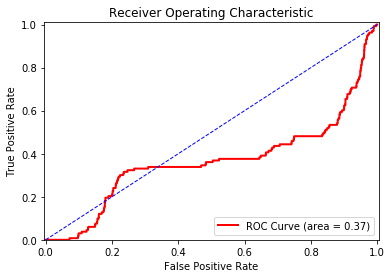

In [13]:
AUC_logreg = metrics.auc(fpr, tpr)

print("AUC: ", AUC_logreg)

plt.figure()

plt.plot(fpr, tpr, color='red', lw=2, label='ROC Curve (area = %0.2f)' % AUC_logreg)
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

plt.xlim([-0.005, 1.005])
plt.ylim([0, 1.01])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.show()

### Linear Regression

<p>Using Linear Regression on the training set. Checking the coefficent's of the model to find the most to least important.</p>

In [14]:
#create classifier
my_linreg = LinearRegression()

#train
my_linreg.fit(X_train, y_train)

#check coefficients, numbers need to be absolute to determin best/worst
coefficients = abs(my_linreg.coef_)

#create tuple list of feature/coefficient pairings and sort by coefficient by descending order
name_coefficient_tuples = list(zip(X.columns, coefficients))
name_coefficient_tuples.sort(key = operator.itemgetter(1), reverse=True)

print("Coefficients in Descending Order:")

for a,b in name_coefficient_tuples:
    print("{:<12}\t\t{}".format(a,b))
    
#print most and least important
print("\n\nMost Important Feature: ", name_coefficient_tuples[0][0])
print("Least Important Feature: ", name_coefficient_tuples[-1][0])

Coefficients in Descending Order:
SnowFall    		15.562262173444221
Longitude   		0.11847377568926619
CULEX ERRATICUS		0.09231507002049179
<= 1 mile   		0.04654972994448538
CULEX PIPIENS		0.04562473246409676
<= 730 days 		0.0391452779807159
> 5 miles   		0.03914527797584118
Latitude    		0.035987593142850396
<= 1/2 mile 		0.027094990229595977
CULEX TARSALIS		0.023627741063725387
PrecipTotal 		0.02111723751594365
StnPressure 		0.015709212525959006
Tmax        		0.013108839214245105
CULEX SALINARIUS		0.011910586304980377
CULEX PIPIENS/RESTUANS		0.010272026484433091
Tavg        		0.010209667026220526
SeaLevel    		0.009349971972830363
CULEX TERRITANS		0.00883757212314404
Tmin        		0.008454608298445522
WetBulb     		0.008063324587536098
CULEX RESTUANS		0.007957588439148905
ResultSpeed 		0.005988409298849465
Cool        		0.0054201645084984386
<= 3 miles  		0.005417185321430351
<= 183 days 		0.0048756718418775935
<= 365 days 		0.004875671840596716
<= 90 days  		0.00487567183727702
Heat  

<p>Predict “balance” for the users in testing set. Then, compare the predicted balance with the actual balance by calculating and reporting the RMSE.</p>

In [15]:
#make prediction from testing data
y_prediction = my_linreg.predict(X_test)

#calculating mean square error (MSE)
mse = metrics.mean_squared_error(y_test, y_prediction)

#RMSE calculation
rmse = np.sqrt(mse)

#print RMSE
print("RMSE: ", rmse)

RMSE:  0.2084310488090178


<p>Use 10-fold Cross-Validation to evaluate the performance of a linear regression in
predicting. Thus, rather than splitting the dataset into testing and training,
use Cross-Validation to evaluate the regression performance.</p>

In [16]:
mse_list = cross_val_score(my_linreg, X, y, cv= 100, scoring='neg_mean_squared_error')
rmse_list = np.sqrt(abs(mse_list))

print("RMSE List: ", rmse_list)
print("\nRMSE Cross-Validation: ", rmse_list.mean())

RMSE List:  [0.02399952 0.03256561 0.03057802 0.0386019  0.04005172 0.04457641
 0.19373245 0.18487449 0.19950945 0.1404966  0.18108334 0.18704236
 0.25698552 0.13275684 0.39819575 0.33742091 0.33231882 0.40142744
 0.35330733 0.4357622  0.35209826 0.33604883 0.28351051 0.22700037
 0.19280208 0.04468669 0.13040398 0.06251626 0.07804629 0.14847236
 0.04006064 0.05062365 0.06528709 0.05853487 0.05615659 1.40788537
 0.0483182  0.06419553 0.07040764 0.06082547 0.05613203 0.18456144
 0.05760372 0.09775506 0.05487162 0.10552739 0.21371256 0.15591753
 0.18510639 0.11126101 0.11996968 0.06681798 0.0257052  0.05595542
 0.04334105 0.06017694 0.07863475 0.10476484 0.08141742 0.05711699
 0.17052858 0.11751709 0.26393323 0.22232353 0.04067467 0.32149376
 0.1652139  0.18116734 0.21408759 0.22788161 0.18638385 0.14770876
 0.26251347 0.10417    0.05104935 0.06003919 0.05099579 0.07702169
 0.11122821 0.14953533 0.17168128 0.24593426 0.27607728 0.23073685
 0.20156836 0.14198705 0.30517062 0.33562731 0.327

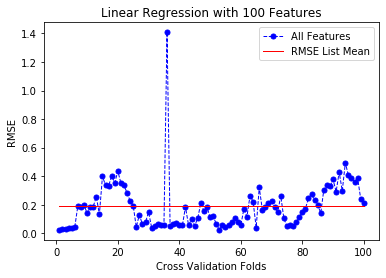

In [17]:
#x-axis tick range
x_values = range(1, len(rmse_list) + 1)

mean_values = [rmse_list.mean()] * len(rmse_list)

#plotting x and y-axis graph markers
line, = plt.plot(x_values, rmse_list, color= 'blue', linestyle = '--', linewidth = 1, marker='o', markerfacecolor = 'blue', markersize = 5, label ='All Features')
line_mean, = plt.plot(x_values, mean_values, color= 'red', linestyle = '-', linewidth = 1, label ='RMSE List Mean')

plt.legend(handles = [line, line_mean])

#x-axis title
plt.xlabel('Cross Validation Folds')

#y-axis title 
plt.ylabel('RMSE') 
  
#graph title
plt.title('Linear Regression with 100 Features')
plt.show()

### Decision Tree

In [18]:
my_decisiontree = DecisionTreeClassifier()

my_decisiontree.fit(X_train, y_train)

y_predict_dt = my_decisiontree.predict(X_test)

print(y_predict_dt)

[0 0 0 ... 0 0 0]


In [19]:
score_dt = accuracy_score(y_test, y_predict_dt)

print("Accuracy :", score_dt)

Accuracy : 0.9032620922384702


<p>Let's see if bagging will produce an accuracy different from one decision tree.</p>

<p>Errors given when n_samples are greater than 79:<br><li>---> 17 accuracy = accuracy_score(y_test, voting)</li><li>ValueError: Input contains NaN, infinity or a value too large for dtype('float64').</li></p>

<p>Why is it that when we use 20 Decision Trees, the voting dataframe has two columns. One column with actual vote data and the other with 'Nan'?</p>  

In [20]:
bootstrap_size = int(0.8 * len(X_train))
predictions = pd.DataFrame()
Base_DecisionTree = DecisionTreeClassifier(random_state = 3)

for i in range(19):
    X_train_i, y_train_i = resample(X_train, y_train, n_samples=bootstrap_size, random_state=i, replace=True)
    Base_DecisionTree.fit(X_train_i, y_train_i)
    predictions[i] = Base_DecisionTree.predict(X_test)

#each column in predictions database is an individual tree with the column being its label outputs

voting = predictions.mode(axis=1)

display(voting)

# vote and compare against y_test
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mode.html (reference)
score_bagging = accuracy_score(y_test, voting)

accuracy_list.append(('Bagging', score_bagging))

print("bootstrap size: ", bootstrap_size)

print("Accuracy: ", score_bagging)

,0
0,0
1,0
2,0
3,0
4,0
...,...
2662,0
2663,0
2664,0
2665,0


bootstrap size:  4978
Accuracy:  0.9403824521934758


### Random Forest

<li>For n_estimators = 19 ---> 0.9373828271466067</li>
<li>For n_estimators = 20 ---> 0.9400074990626172</li>

In [21]:
my_RandomForest = RandomForestClassifier(n_estimators=bootstrap_size, bootstrap=True, random_state=3)

my_RandomForest.fit(X_train, y_train)

y_predict_rf = my_RandomForest.predict(X_test)

score_rf = accuracy_score(y_test, y_predict_rf)

accuracy_list.append(('Random Forest', score_rf))

print('Accuracy: ', score_rf)

Accuracy:  0.9422572178477691


### KNN

In [22]:
k = len(X_train)
my_knn = KNeighborsClassifier(n_neighbors=k)
my_knn.fit(X_train, y_train)
y_predict = my_knn.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
print("Accuracy: ", accuracy)

Accuracy:  0.9501312335958005


<p>Wanted to make sure that WnvPresent wasn't all zeros.</p>

In [23]:
final_df['WnvPresent'].value_counts()

0    8429
1     461
Name: WnvPresent, dtype: int64

<p>The same for y_test.</p>

In [24]:
y_test.value_counts()

0    2534
1     133
Name: WnvPresent, dtype: int64

In [25]:
k_list = [1, 100, 500, 1000, 2000, 3000, 4000, 5000, len(X_train)]
accuracy_list_knn = []

for k in k_list:
    my_knn = KNeighborsClassifier(n_neighbors=k)
    my_knn.fit(X_train, y_train)
    y_predict = my_knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)
    accuracy_list_knn.append(accuracy)
    
print(accuracy_list_knn)

[0.9212598425196851, 0.9501312335958005, 0.9501312335958005, 0.9501312335958005, 0.9501312335958005, 0.9501312335958005, 0.9501312335958005, 0.9501312335958005, 0.9501312335958005]


### What would happen if we just dropped all the spray data?

In [26]:
cols_to_drop = ['<= 90 days', '<= 183 days', '<= 365 days', '<= 730 days', '> 730 days',
              '<= 1/2 mile', '<= 1 mile', '<= 3 miles', '<= 5 miles', '> 5 miles']

final_df.drop(cols_to_drop, axis=1, inplace=True)

final_df.columns

Index(['Trap', 'Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent',
       'CULEX ERRATICUS', 'CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS',
       'CULEX RESTUANS', 'CULEX SALINARIUS', 'CULEX TARSALIS',
       'CULEX TERRITANS', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Depth', 'SnowFall', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'Station 1', 'Station 2', 'Date Ordinal'],
      dtype='object')

In [27]:
feature_columns = final_df.columns.difference(['WnvPresent'])

X = final_df[feature_columns]

y = final_df['WnvPresent']

display(X.head(3), y.head(3))

# Randomly splitting the original dataset into training set and testing set:
#Test size 30% Train size 70% 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

# print the size of the traning set:
print(X_train.shape)
print(y_train.shape)

# print the size of the testing set:
print(X_test.shape)
print(y_test.shape)

print("\nValue count of y_test:\n", y_test.value_counts())

,AvgSpeed,CULEX ERRATICUS,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX SALINARIUS,CULEX TARSALIS,CULEX TERRITANS,Cool,Date Ordinal,...,SeaLevel,SnowFall,Station 1,Station 2,StnPressure,Tavg,Tmax,Tmin,Trap,WetBulb
0,6.5,0,0,1,0,0,0,0,9.0,732825,...,30.11,0.0,1,0,29.39,74.0,88.0,60.0,1,65.0
1,6.5,0,0,0,1,0,0,0,9.0,732825,...,30.11,0.0,1,0,29.39,74.0,88.0,60.0,1,65.0
2,6.5,0,0,0,1,0,0,0,9.0,732825,...,30.11,0.0,1,0,29.39,74.0,88.0,60.0,6,65.0


0    0
1    0
2    0
Name: WnvPresent, dtype: int64

(6223, 30)
(6223,)
(2667, 30)
(2667,)

Value count of y_test:
 0    2534
1     133
Name: WnvPresent, dtype: int64


[0 0 0 ... 0 0 0]
0.9501312335958005
AUC:  0.36565417094433006


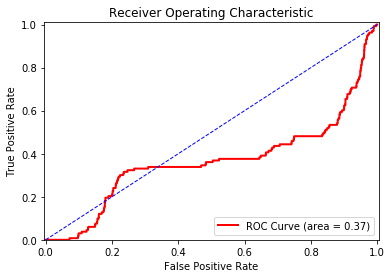

In [28]:
my_logreg_no_spray = LogisticRegression(solver='liblinear')

# Training ONLY on the training set:
my_logreg_no_spray.fit(X_train, y_train)

# Testing on the testing set:
y_predict_lr = my_logreg_no_spray.predict(X_test)
print(y_predict_lr)

# We can now compare the "predicted labels" for the Testing Set with its "actual labels" to evaluate the accuracy 

score_lr = accuracy_score(y_test, y_predict_lr)

accuracy_list.append(('Logistic Regression', score_lr))

print(score_lr)

# Predicting the Binary Label:
y_predict_lr = my_logreg_no_spray.predict(X_test)

# Estimating the probability (likelihood) of Each Label: 
y_predict_prob_lr = my_logreg_no_spray.predict_proba(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob_lr[:,1], pos_label=1)

AUC_logreg = metrics.auc(fpr, tpr)

print("AUC: ", AUC_logreg)

plt.figure()

plt.plot(fpr, tpr, color='red', lw=2, label='ROC Curve (area = %0.2f)' % AUC_logreg)
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

plt.xlim([-0.005, 1.005])
plt.ylim([0, 1.01])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.show()

In [29]:
final_df['SnowFall'].value_counts()

0.000    8820
0.005      70
Name: SnowFall, dtype: int64